### IBTrACS data
For historical typhoon events we used IBTrACS data, which comes from the IBTracs project

The IBTrACS project:
    Contains the most complete global set of historical tropical cyclones available
    Combines information from numerous tropical cyclone datasets
    Simplifies inter-agency comparisons by providing storm data from multiple sources in one place
    Combines recent and historical storm data in one dataset


### Parametric wind field modelling 

A parametric representation of the pressure and wind field in tropical cyclones facilitates abstract representation of these meteorological systems using just a few physically meaningful parameters [Depperman, 1947; Holland, 1980; Jelesnianski, 1965; Schloemer, 1954]. These include the central pressure deficit, the maximum wind speed, and the radius to the maximum wind speed.
for our Project we used parametric wind field model based on the Holands 2008 method 

In [9]:
#%% import libraries from local directory
import os
import sys
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
from os.path import relpath
from pybufrkit.decoder import Decoder
from geopandas.tools import sjoin
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.ops import nearest_points

wor_dir="C:\\Users\\ATeklesadik\\OneDrive - Rode Kruis\\Documents\\documents\\Typhoon-Impact-based-forecasting-model"



# Importing local libraries

sys.path.insert(0, wor_dir+'\\IBF-Typhoon-model\\src')
 
decoder = Decoder()
         
from climada.hazard import Centroids, TropCyclone, TCTracks
from climada.hazard.tc_tracks import estimate_roci, estimate_rmw
from climada.hazard.tc_tracks_forecast import TCForecast

os.chdir(wor_dir)
cdir = os.getcwd()

## Define functions

In [27]:
def adjust_tracks(forcast_df):
        track = xr.Dataset(
            data_vars={
                "max_sustained_wind": (
                    "time",
                    0.514444
                    * forcast_df.max_sustained_wind.values,  # conversion from kn to meter/s
                ),
                "environmental_pressure": (
                    "time",
                    forcast_df.environmental_pressure.values,
                ),
                "central_pressure": ("time", forcast_df.central_pressure.values),
                "lat": ("time", forcast_df.lat.values),
                "lon": ("time", forcast_df.lon.values),
                "radius_max_wind": ("time", forcast_df.radius_max_wind.values),
                "radius_oci": ("time", forcast_df.radius_oci.values),
                "time_step": (
                    "time",
                    np.full_like(forcast_df.time_step.values, 3, dtype=float),
                ),
            },
            coords={"time": forcast_df.time.values,},
            attrs={
                "max_sustained_wind_unit": "m/s",
                "central_pressure_unit": "mb",
                "name": forcast_df.name,
                "sid": forcast_df.sid,  # +str(forcast_df.ensemble_number),
                "orig_event_flag": forcast_df.orig_event_flag,
                "data_provider": forcast_df.data_provider,
                "id_no": forcast_df.id_no,
                "basin": forcast_df.basin,
                "category": forcast_df.category,
            },
        )
        track = track.set_coords(["lat", "lon"])
        return track

114.27790168600006 4.587294497000073 126.60482466300004 21.12180803600006


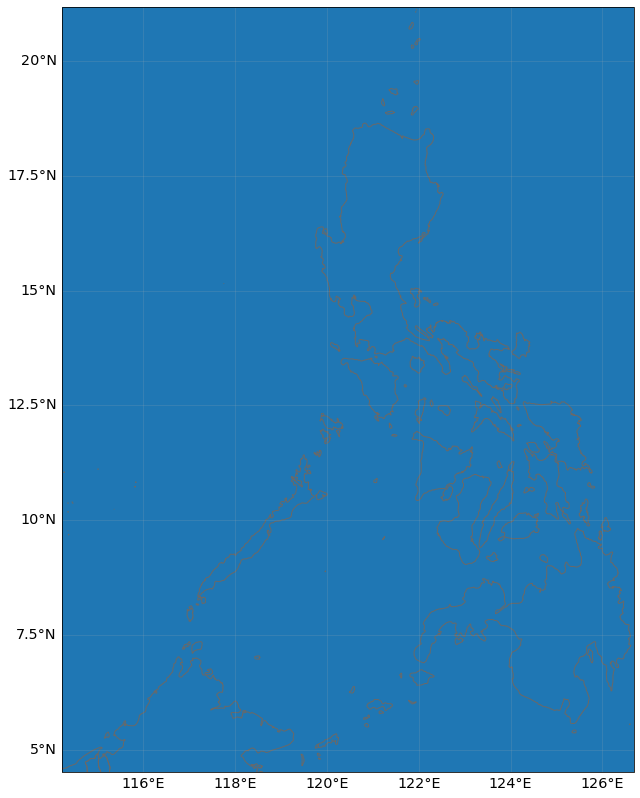

In [10]:
#%%######################################################
####### VARIABLES TO SET
#########################################################
year_range = (2006, 2020)

# Laoding PH admin file and setting centroids
# Instead of one grid point for each municipalities: uses a range of gridpoints
# calculates value for each point
# Eventually select a specific point in municipality based on condition
# maximum windspeed and minimum track distance
file_name = "IBF-Typhoon-model\\data\\wind_data\\input\\phl_admin3_simpl2.geojson"
path = os.path.join(cdir, file_name)
admin = gpd.read_file(path)

minx, miny, maxx, maxy = admin.total_bounds
print(minx, miny, maxx, maxy)

cent = Centroids()
cent.set_raster_from_pnt_bounds((minx, miny, maxx, maxy), res=0.05)
cent.check()
cent.plot()
plt.show()
plt.close()

# Loads an excel sheet with Local_name, International_Name and year

# Setting directory for typhoon metadata csv file
typhoon_metadata_filename = os.path.join(wor_dir, "IBF-Typhoon-model\\data\\rainfall_data\\input\\metadata_typhoons.csv")
typhoon_metadata = pd.read_csv(typhoon_metadata_filename, delimiter=",")


In [28]:
typhoon_events = list(typhoon_metadata.typhoon.values)
typhoon_events=[event.upper() for event in typhoon_events]

['DURIAN2006']
2021-09-21 15:25:11,351 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


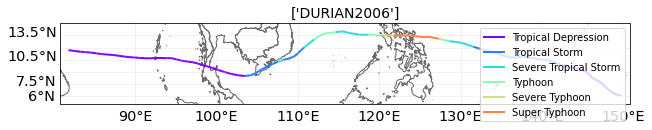

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


DURIAN


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['FENGSHEN2008']
2021-09-21 15:26:19,997 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


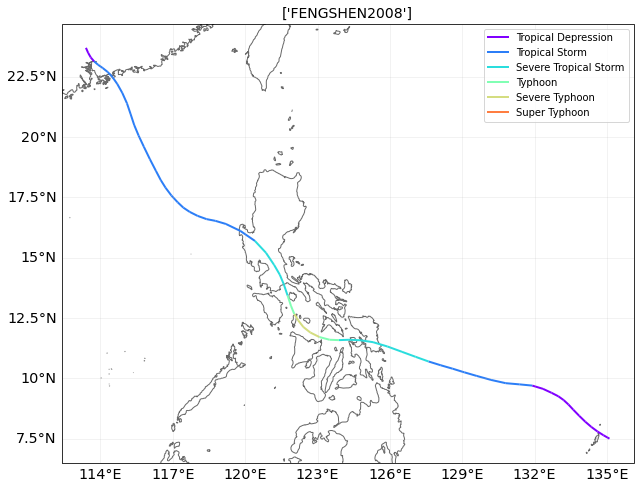

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


FENGSHEN


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['AERE2011']
2021-09-21 15:27:23,243 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


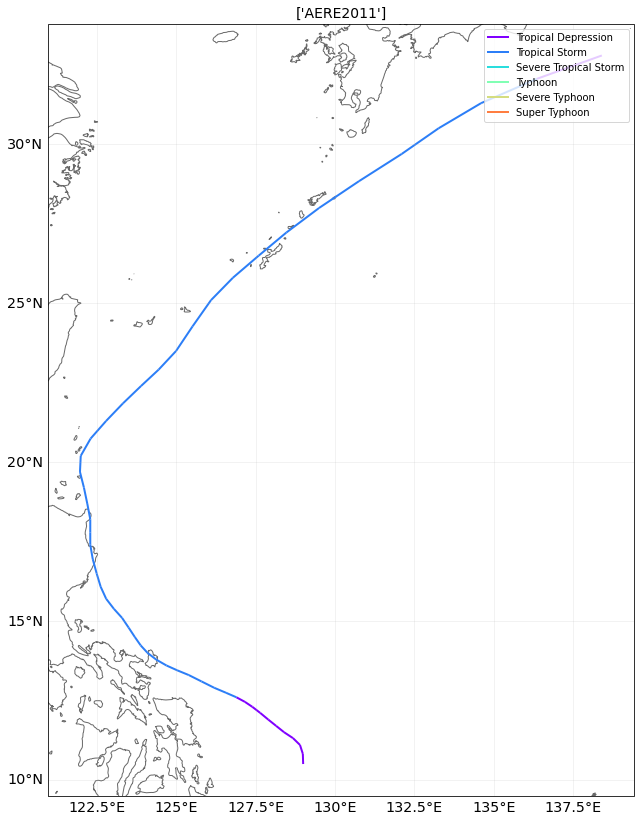

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


AERE


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['ATSANI2020']
2021-09-21 15:28:21,843 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


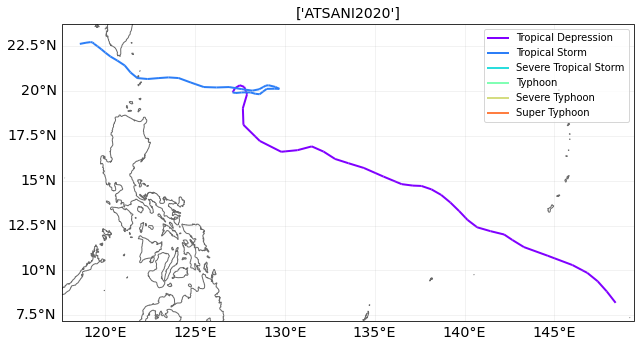

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


ATSANI


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['BOPHA2012']
2021-09-21 15:29:18,203 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


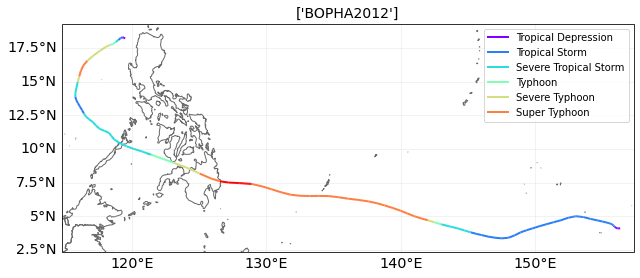

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


BOPHA


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['DANAS2019']
2021-09-21 15:30:27,835 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


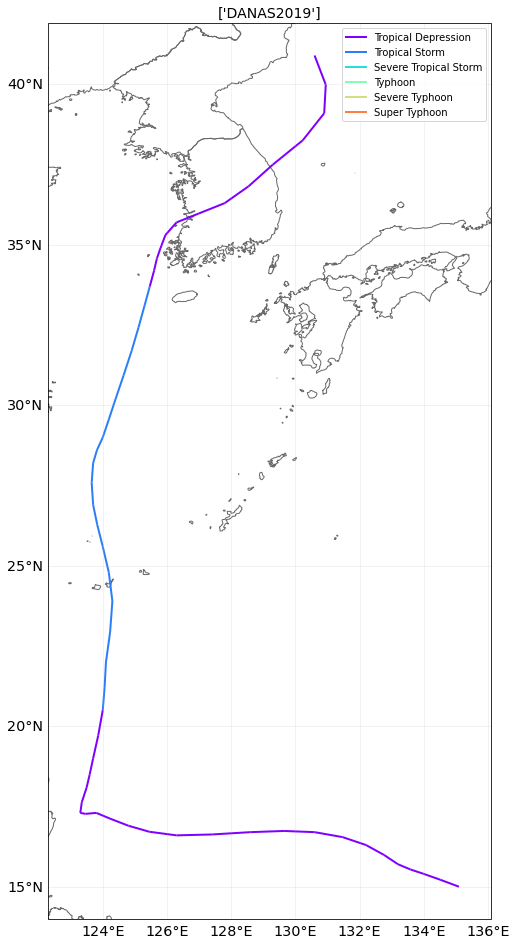

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


DANAS


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['FUNG-WONG2014']
2021-09-21 15:31:22,996 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


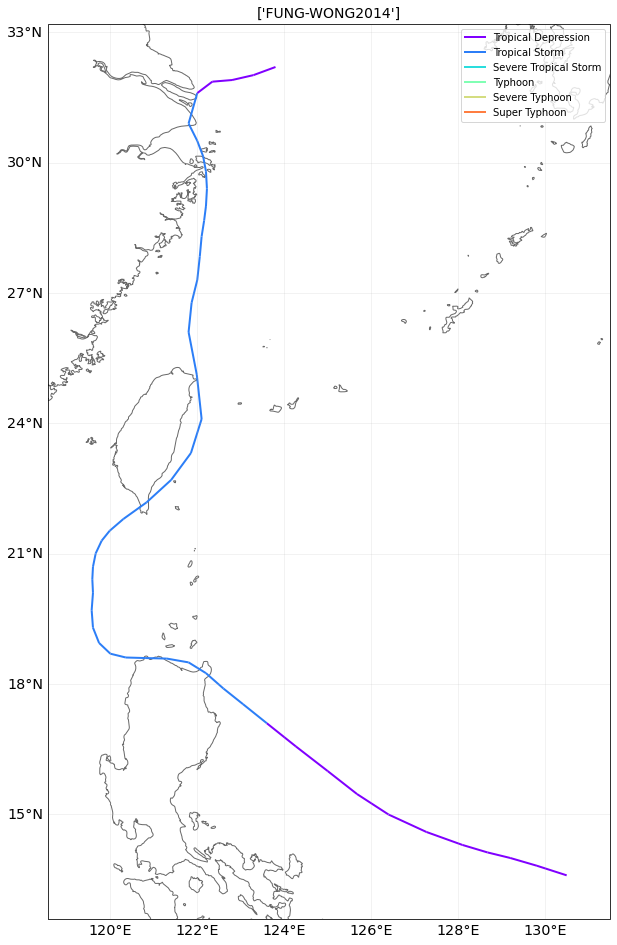

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


FUNG-WONG


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['GONI2015']
2021-09-21 15:32:19,850 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


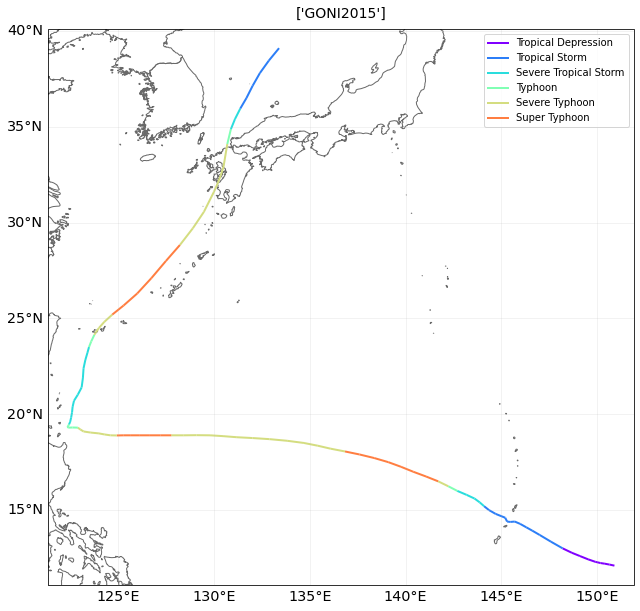

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


GONI


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['GONI2020']
2021-09-21 15:33:18,991 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


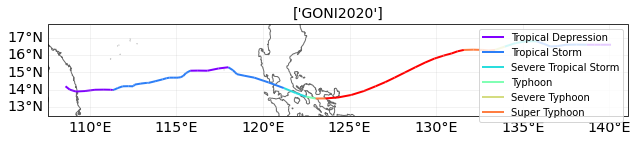

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


GONI


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['HAGUPIT2014']
2021-09-21 15:34:20,502 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


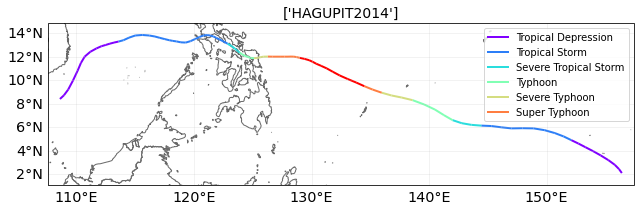

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


HAGUPIT


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['HAIKUI2017']
2021-09-21 15:35:28,531 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


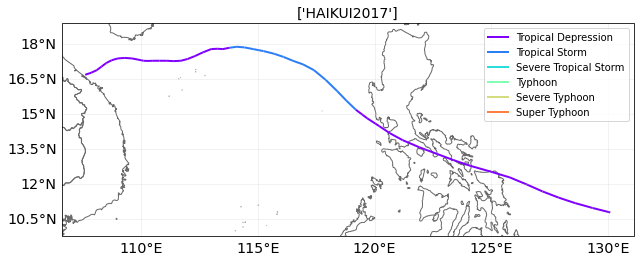

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


HAIKUI


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['HAIMA2016']
2021-09-21 15:36:27,681 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


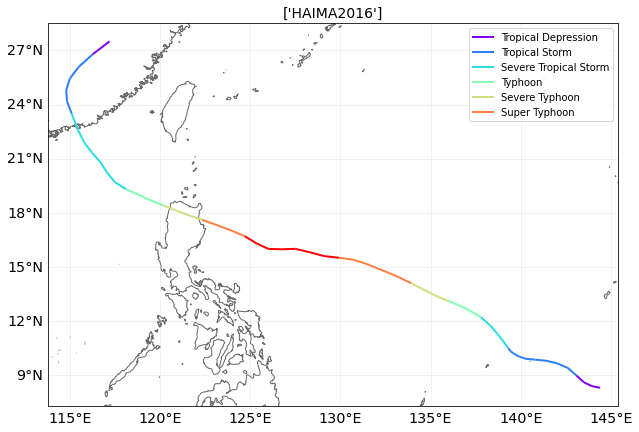

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


HAIMA


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['HAIYAN2013']
2021-09-21 15:37:25,814 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


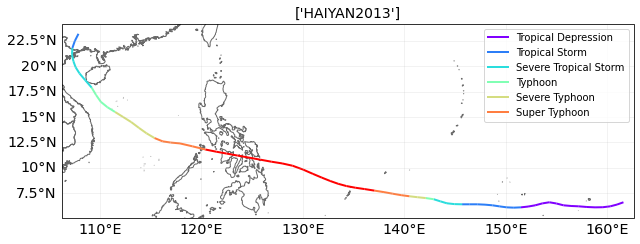

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


HAIYAN


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['JANGMI2014']
2021-09-21 15:38:27,887 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


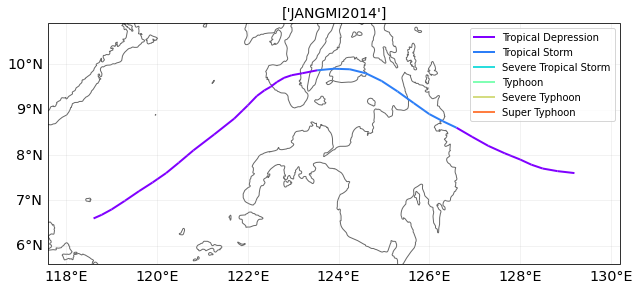

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


JANGMI


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['KAI-TAK2012']
2021-09-21 15:39:23,201 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


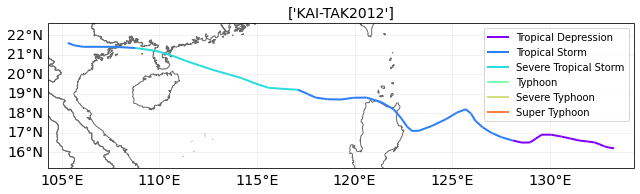

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


KAI-TAK


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['KAI-TAK2017']
2021-09-21 15:40:21,740 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


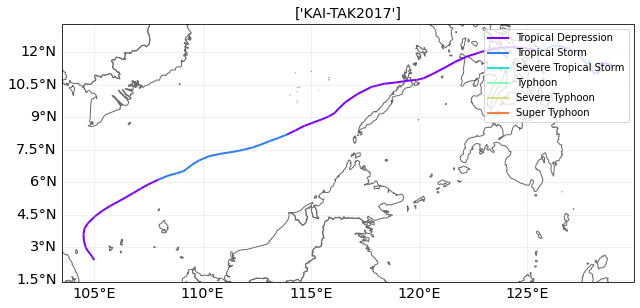

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


KAI-TAK


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['KALMAEGI2014']
2021-09-21 15:41:36,427 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


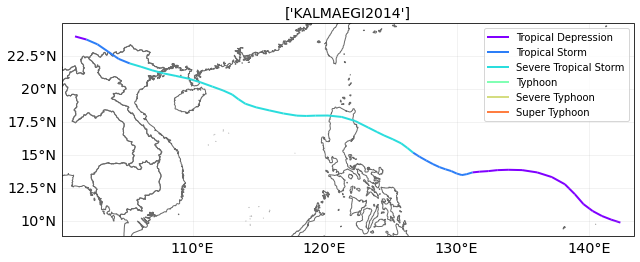

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


KALMAEGI


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['KAMMURI2019']
2021-09-21 15:43:23,091 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


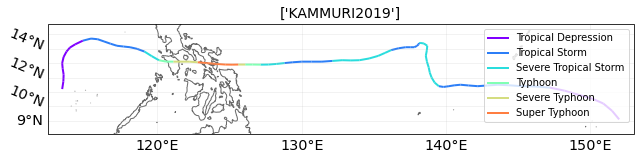

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


KAMMURI


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['KETSANA2009']
2021-09-21 15:45:21,072 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


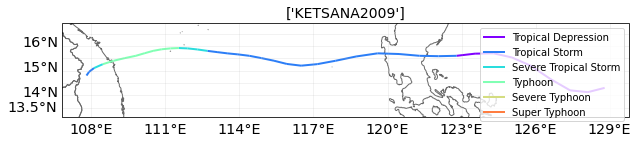

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


KETSANA


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['KHANUN2017']
2021-09-21 15:47:09,974 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


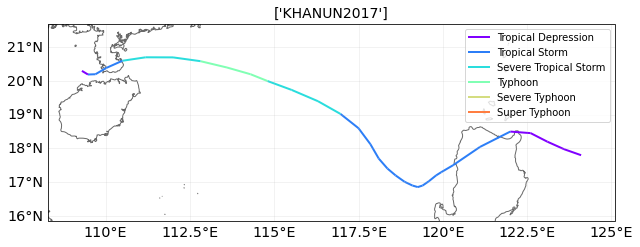

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


KHANUN


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['KOMPASU2010']
2021-09-21 15:48:58,263 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


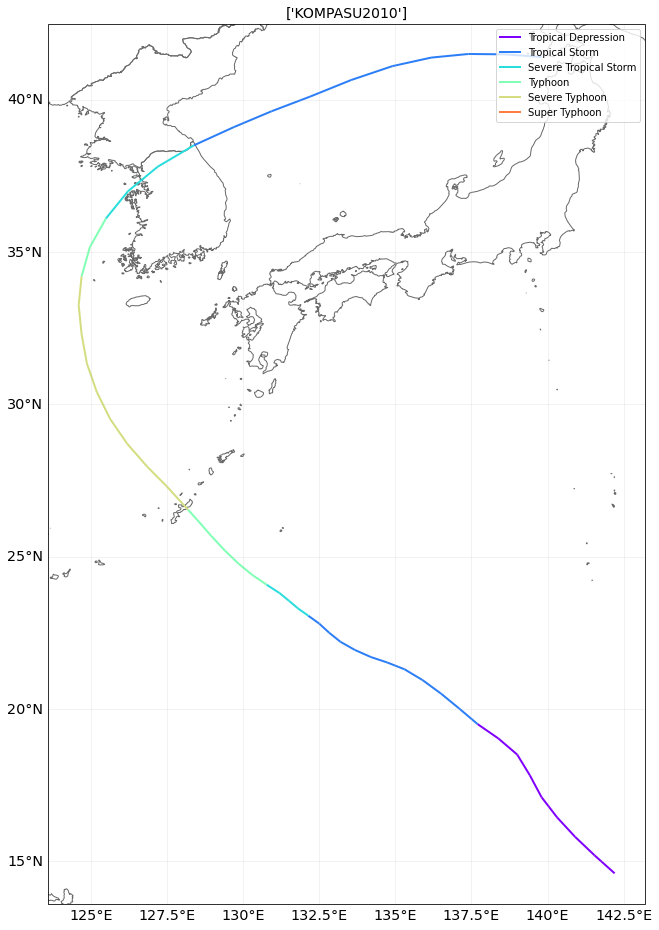

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


KOMPASU


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['KOPPU2015']
2021-09-21 15:50:38,530 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


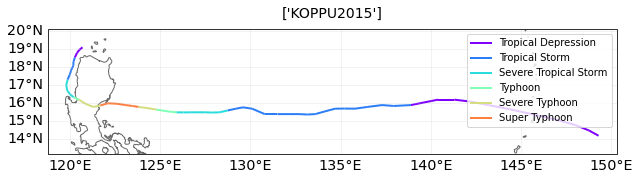

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


KOPPU


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['KROSA2013']
2021-09-21 15:52:31,481 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


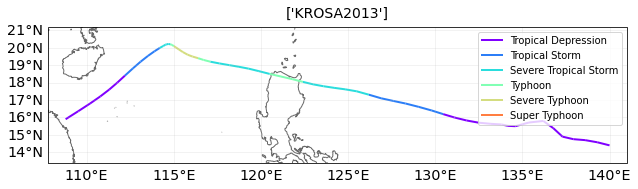

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


KROSA


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['LINFA2015']
2021-09-21 15:54:20,083 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


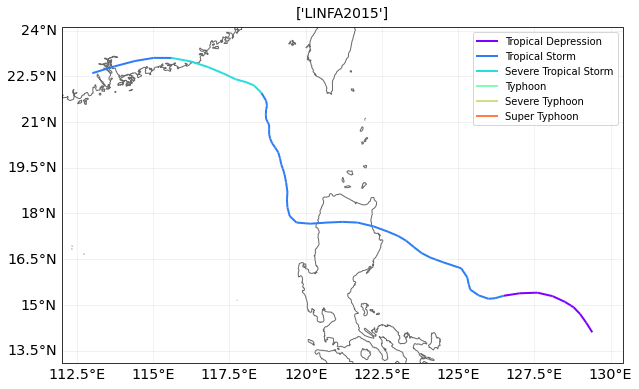

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


LINFA


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['LINGLING2014']
2021-09-21 15:56:08,916 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


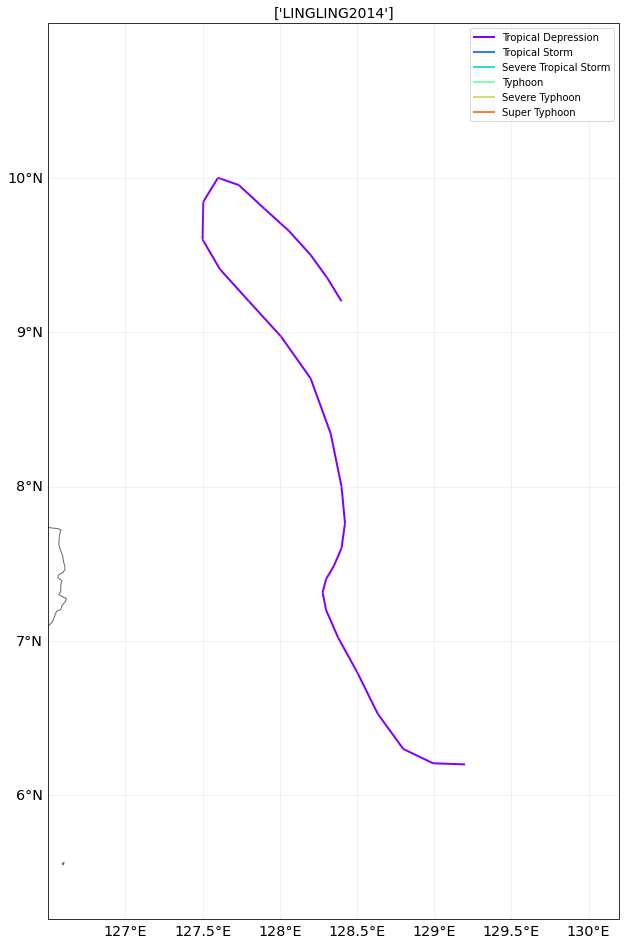

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


LINGLING


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['MALIKSI2018']
2021-09-21 15:57:50,570 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


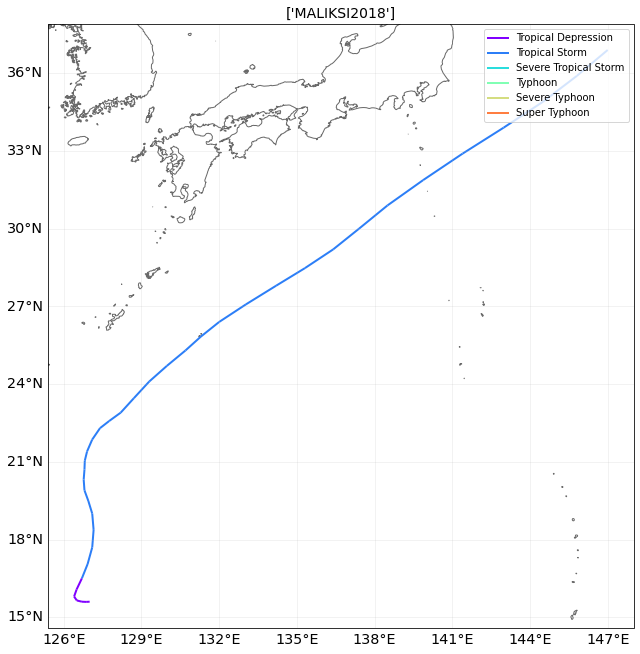

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


MALIKSI


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['MANGKHUT2018']
2021-09-21 15:59:33,130 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


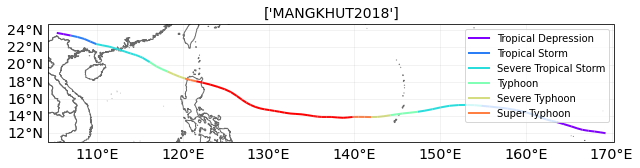

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


MANGKHUT


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['MATMO2014']
2021-09-21 16:01:29,727 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


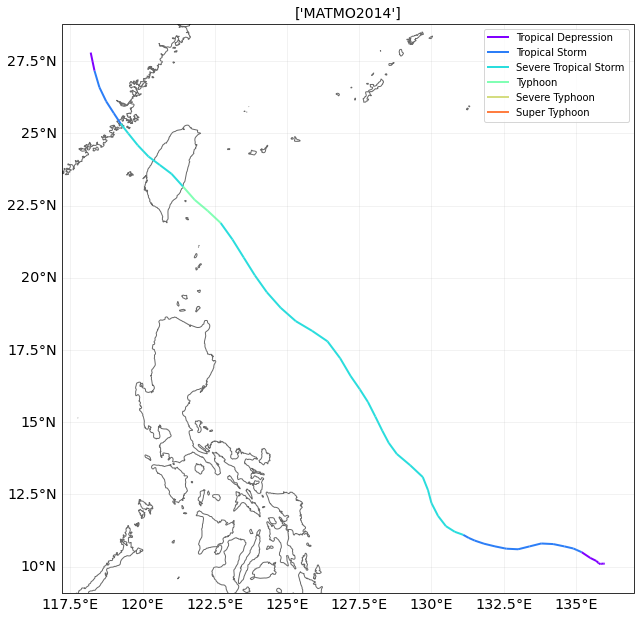

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


MATMO


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['MEARI2011']
2021-09-21 16:03:12,834 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


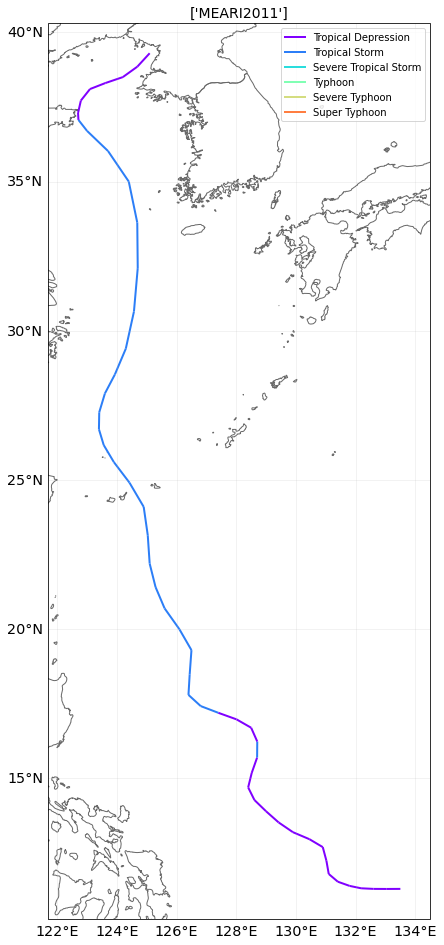

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


MEARI


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['MEKKHALA2015']
2021-09-21 16:04:56,281 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


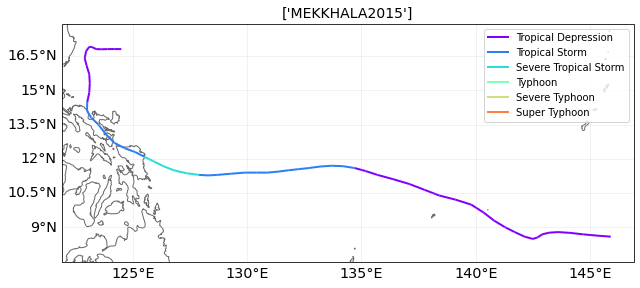

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


MEKKHALA


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['MELOR2015']
2021-09-21 16:06:48,850 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


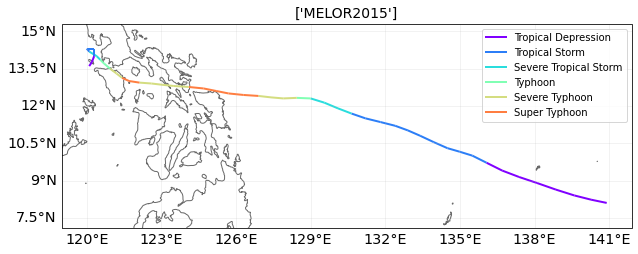

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


MELOR


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['MIRINAE2009']
2021-09-21 16:08:38,130 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


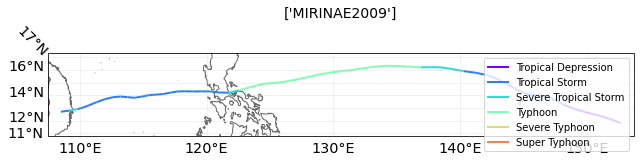

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


MIRINAE


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['MOLAVE2020']
2021-09-21 16:10:30,358 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


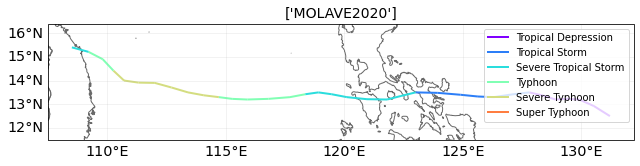

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


MOLAVE


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['MUJIGAE2015']
2021-09-21 16:12:12,683 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


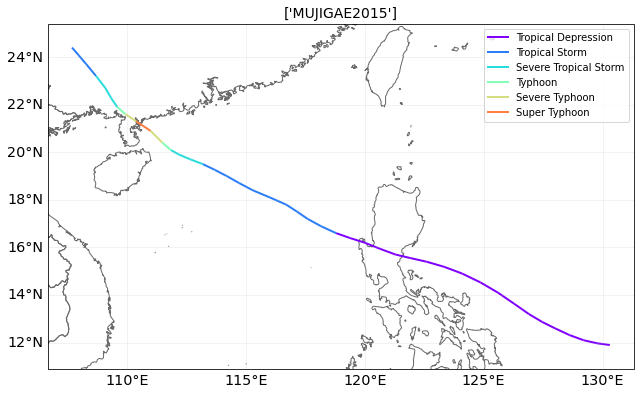

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


MUJIGAE


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['NAKRI2019']
2021-09-21 16:24:42,365 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


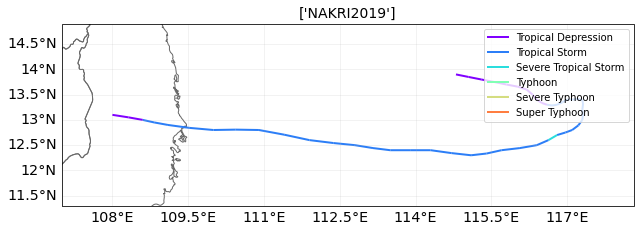

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


NAKRI


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['NALGAE2011']
2021-09-21 16:25:42,326 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


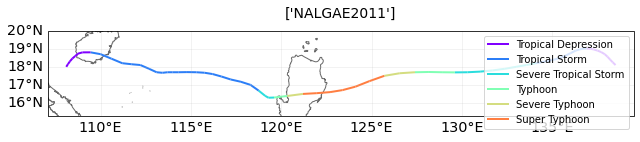

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


NALGAE


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['NANMADOL2011']
2021-09-21 16:26:42,213 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


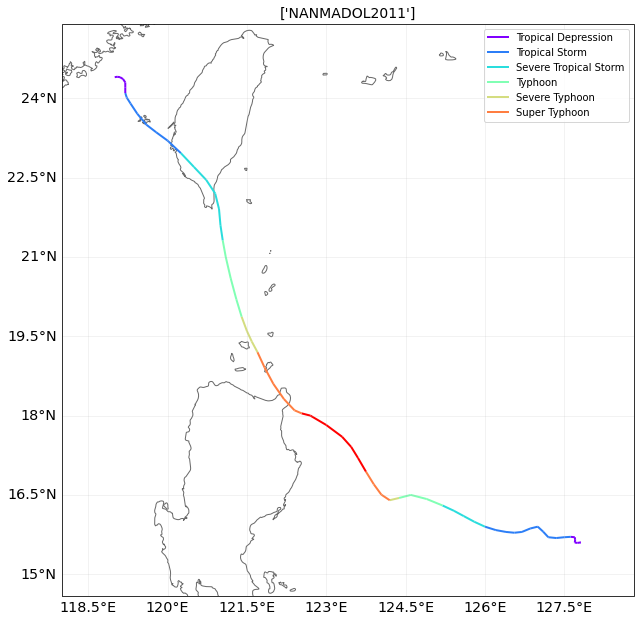

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


NANMADOL


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['NARI2013']
2021-09-21 16:27:41,871 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


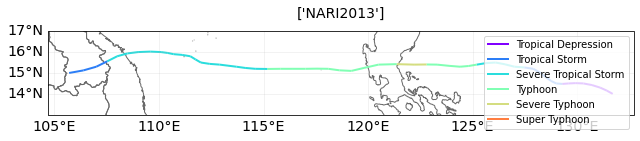

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


NARI


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['NESAT2011']
2021-09-21 16:28:40,566 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


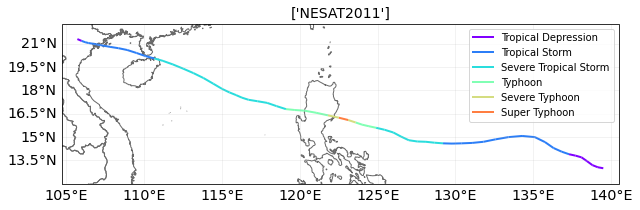

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


NESAT


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['NOCK-TEN2011']
2021-09-21 16:29:39,942 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


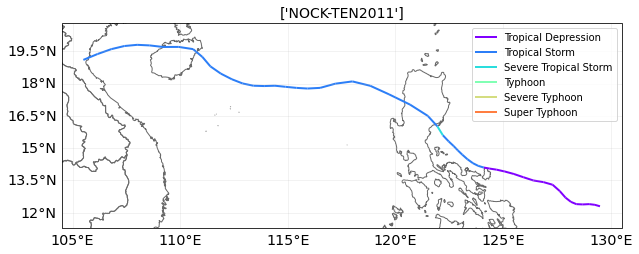

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


NOCK-TEN


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['NOCK-TEN2016']
2021-09-21 16:30:38,512 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


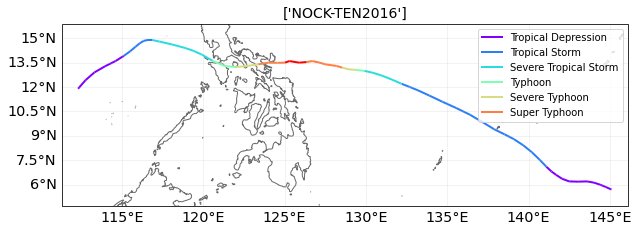

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


NOCK-TEN


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['PAKHAR2017']
2021-09-21 16:31:43,930 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


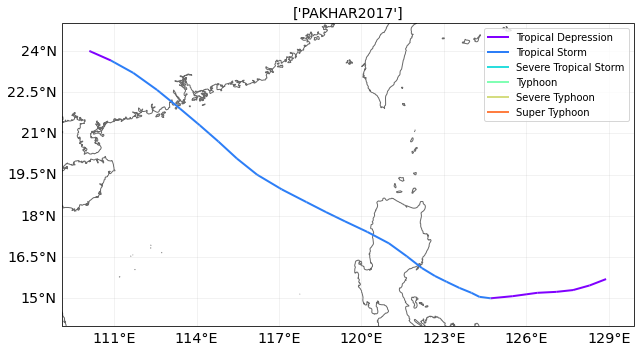

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


PAKHAR


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['PARMA2009']
2021-09-21 16:32:40,764 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


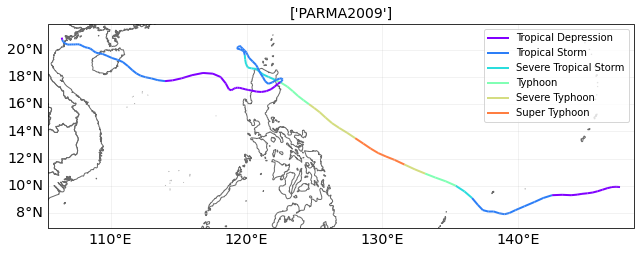

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


PARMA


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['PHANFONE2019']
2021-09-21 16:33:59,426 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


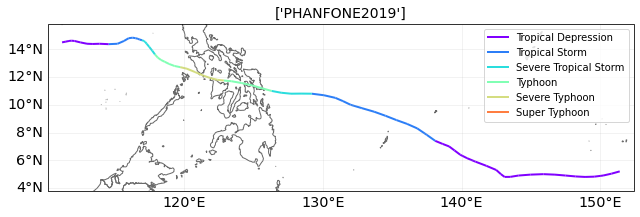

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


PHANFONE


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['RAMMASUN2014']
2021-09-21 16:35:05,796 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


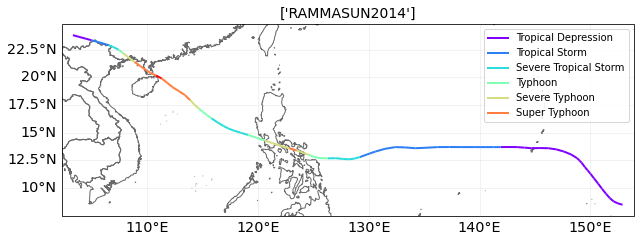

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


RAMMASUN


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['SARIKA2016']
2021-09-21 16:36:10,361 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


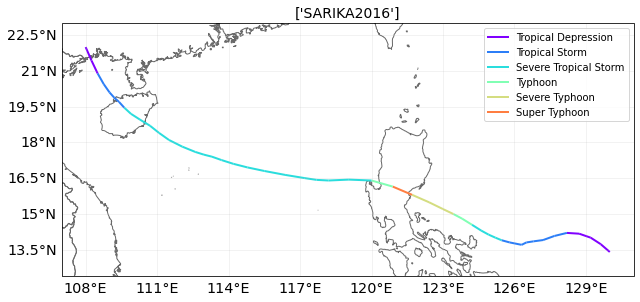

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


SARIKA


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['SAUDEL2020']
2021-09-21 16:37:08,718 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


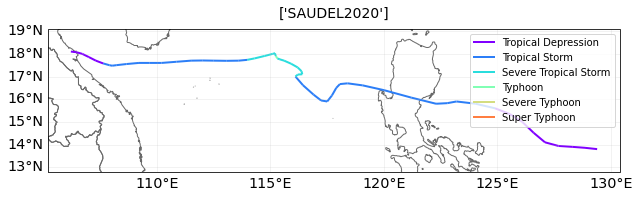

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


SAUDEL


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['TEMBIN2017']
2021-09-21 16:38:09,507 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


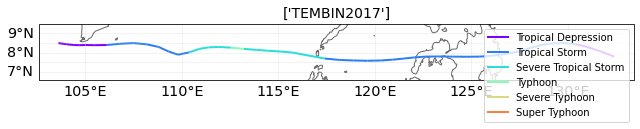

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


TEMBIN


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['TOKAGE2016']
2021-09-21 16:39:06,497 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


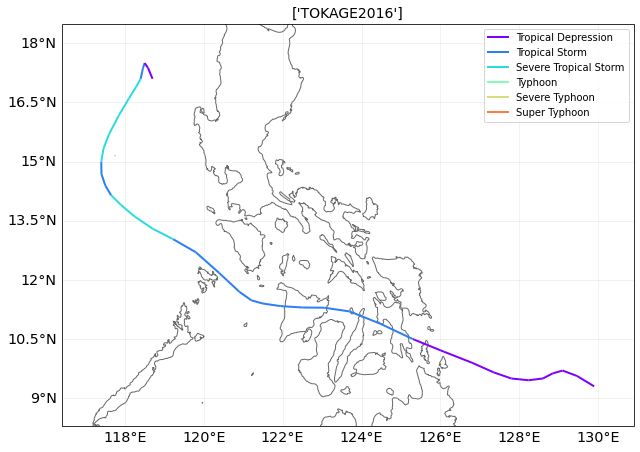

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


TOKAGE


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['TRAMI2013']
2021-09-21 16:40:04,922 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


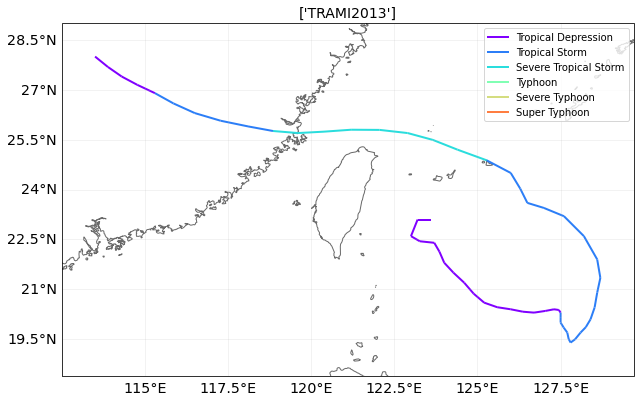

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


TRAMI


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['USAGI2013']
2021-09-21 16:41:01,316 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


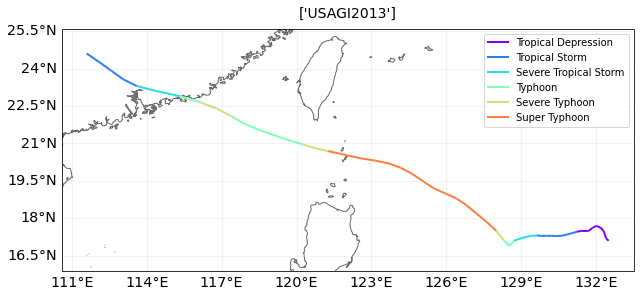

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


USAGI


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['UTOR2013']
2021-09-21 16:41:57,692 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


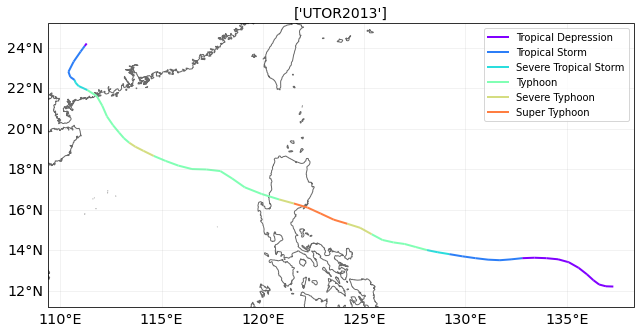

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


UTOR


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['VAMCO2020']
2021-09-21 16:42:56,789 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


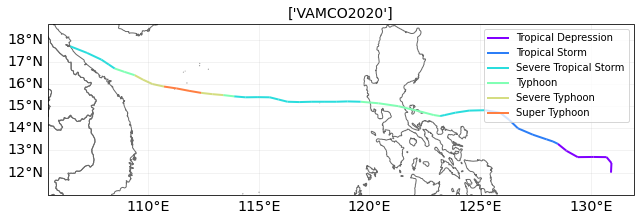

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


VAMCO


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['VONGFONG2020']
2021-09-21 16:43:58,929 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


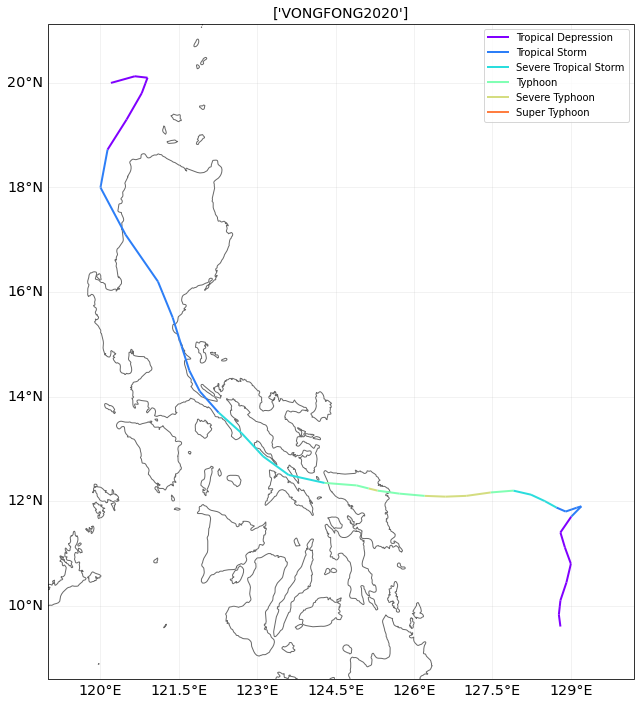

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


VONGFONG


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['WASHI2011']
2021-09-21 16:44:55,915 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


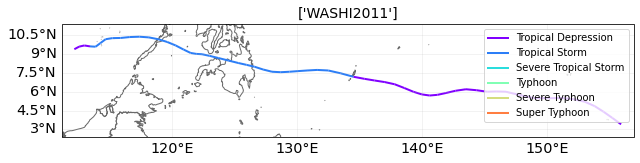

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


WASHI


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['YUTU2018']
2021-09-21 16:45:54,211 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


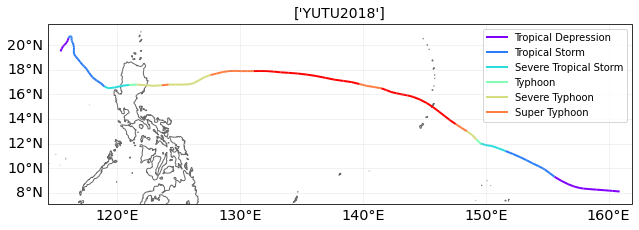

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


YUTU


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['CONSON2010']
2021-09-21 16:46:59,027 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


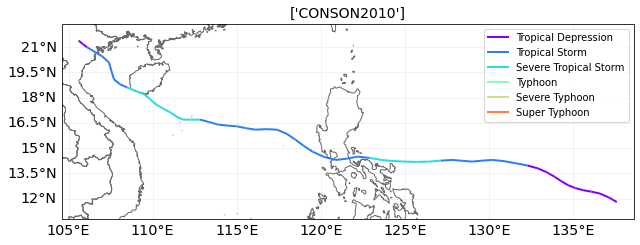

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


CONSON


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['MERANTI2016']
2021-09-21 16:47:58,983 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


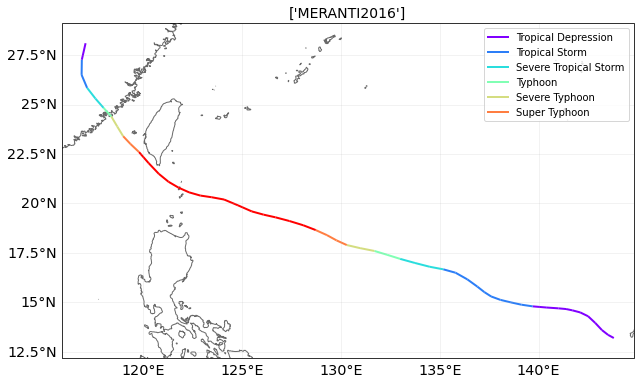

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


MERANTI


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities
['NOUL2015']
2021-09-21 16:48:55,577 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


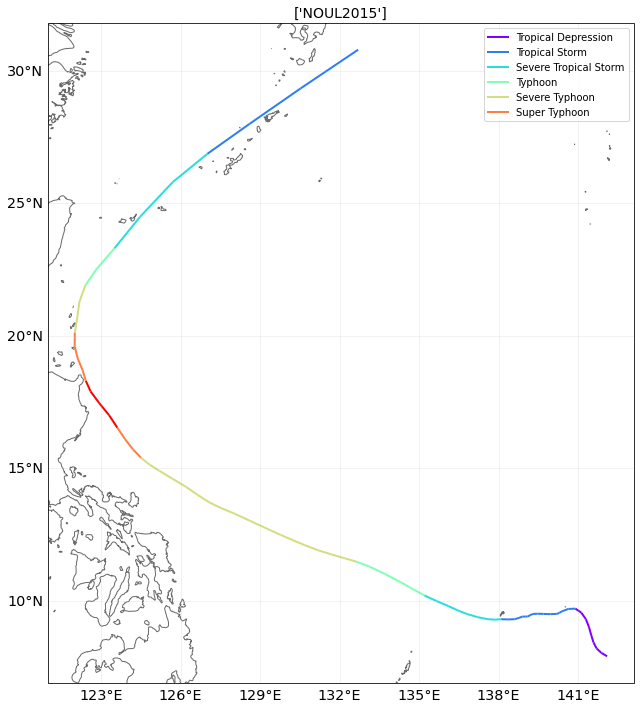

C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


NOUL


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 87 missing municipalities
There are 0 missing municipalities


In [30]:
#%%######################################################
####### START PROCESSING
#########################################################

for typhoon_name in typhoon_events:

    typoon_event = [typhoon_name]
    print(typoon_event)

    sel_ibtracs = TCTracks()
    # Set year range for which data should be collected
    sel_ibtracs.read_ibtracs_netcdf(
        provider="usa", year_range=year_range, basin="WP", correct_pres=False
    )

    Typhoons = TCTracks()
    # Select typhoons that are in the typhoon event sheet
    Typhoons.data = [
        tr for tr in sel_ibtracs.data if (tr.name + tr.sid[:4]) in typoon_event
    ]

    # Plot the typhoon track
    ax = Typhoons.plot()
    ax.get_legend()._loc = 1
    ax.set_title(typoon_event, fontsize=14)
    plt.show()
    plt.close()

    # Select names and storm id's of storms
    names = [[tr.name, tr.sid] for tr in Typhoons.data]

    df = pd.DataFrame(data=cent.coord)
    df["centroid_id"] = "id" + (df.index).astype(str)
    centroid_idx = df["centroid_id"].values
    ncents = cent.size
    df = df.rename(columns={0: "lat", 1: "lon"})   
    tracks = TCTracks()
    tracks.data = [adjust_tracks(tr) for tr in Typhoons.data]
    tracks.equal_timestep(0.5)

    # define a new typhoon class
    TYphoon = TropCyclone()
    TYphoon.set_from_tracks(tracks, cent, store_windfields=True)

    # plot intensity
    #TYphoon.plot_intensity(event=Typhoons.data[0].sid)
    #plt.show()
    #plt.close()

    df = pd.DataFrame(data=cent.coord)
    df["centroid_id"] = "id" + (df.index).astype(str)
    centroid_idx = df["centroid_id"].values
    ncents = cent.size
    df = df.rename(columns={0: "lat", 1: "lon"})
    threshold = 0.1

    list_intensity = []
    distan_track = []

    for tr in tracks.data:
        print(tr.name)

        track = TCTracks()
        typhoon = TropCyclone()
        track.data = [tr]
        typhoon.set_from_tracks(track, cent, store_windfields=True)
        windfield = typhoon.windfields
        nsteps = windfield[0].shape[0]
        centroid_id = np.tile(centroid_idx, nsteps)
        intensity_3d = windfield[0].toarray().reshape(nsteps, ncents, 2)
        intensity = np.linalg.norm(intensity_3d, axis=-1).ravel()

        timesteps = np.repeat(tr.time.values, ncents)
        timesteps = timesteps.reshape((nsteps, ncents)).ravel()
        inten_tr = pd.DataFrame(
            {"centroid_id": centroid_id, "value": intensity, "timestamp": timesteps,}
        )

        inten_tr = inten_tr[inten_tr.value > threshold]

        inten_tr["storm_id"] = tr.sid
        list_intensity.append(inten_tr)
        distan_track1 = []
        for index, row in df.iterrows():
            dist = np.min(
                np.sqrt(
                    np.square(tr.lat.values - row["lat"])
                    + np.square(tr.lon.values - row["lon"])
                )
            )
            distan_track1.append(dist * 111)
        dist_tr = pd.DataFrame({"centroid_id": centroid_idx, "value": distan_track1})
        dist_tr["storm_id"] = tr.sid
        distan_track.append(dist_tr)

    df_ = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))
    df_.crs = {"init": "epsg:4326"}
    df_ = df_.to_crs("EPSG:4326")
    df_admin = sjoin(df_, admin, how="left")
    # To remove points that are in water
    df_admin = df_admin.dropna()

    # For some municipalities, there is missing data
    # For these, fill with the value of the nearest centroid with data observed
    mun_missing = admin[admin["adm3_pcode"].isin(df_admin["adm3_pcode"]) == False]
    print(f"There are {len(mun_missing)} missing municipalities")

    mun_missing_points = gpd.GeoDataFrame(
        mun_missing, geometry=gpd.points_from_xy(mun_missing.glon, mun_missing.glat)
    )
    pts3 = df_admin.geometry.unary_union

    def near(point, pts=pts3):
        # find the nearest point and return the corresponding Place value
        nearest = df_admin.geometry == nearest_points(point, pts)[1]
        # display(df_admin[nearest].centroid_id.values[0])
        return df_admin[nearest].centroid_id.values[0]

    mun_missing_points["centroid_id"] = mun_missing_points.apply(
        lambda row: near(row.geometry), axis=1
    )

    def match_values_lat(x):

        return df_admin["lat"][df_admin["centroid_id"] == x].values[0]

    def match_values_lon(x):

        return df_admin["lon"][df_admin["centroid_id"] == x].values[0]

    def match_values_geo(x):

        return df_admin["geometry"][df_admin["centroid_id"] == x].values[0]

    mun_missing_points["lat"] = mun_missing_points["centroid_id"].apply(
        match_values_lat
    )
    mun_missing_points["lon"] = mun_missing_points["centroid_id"].apply(
        match_values_lon
    )
    mun_missing_points["geometry"] = mun_missing_points["centroid_id"].apply(
        match_values_geo
    )

    df_admin = df_admin[
        [
            "adm3_en",
            "adm3_pcode",
            "adm2_pcode",
            "adm1_pcode",
            "glat",
            "glon",
            "lat",
            "lon",
            "centroid_id",
        ]
    ]

    mun_missing_points = mun_missing_points[
        [
            "adm3_en",
            "adm3_pcode",
            "adm2_pcode",
            "adm1_pcode",
            "glat",
            "glon",
            "lat",
            "lon",
            "centroid_id",
        ]
    ]

    df_admin = pd.concat([df_admin, mun_missing_points])
    mun_missing = admin[admin["adm3_pcode"].isin(df_admin["adm3_pcode"]) == False]
    print(f"There are {len(mun_missing)} missing municipalities")

    df_intensity = pd.concat(list_intensity)
    df_intensity = pd.merge(df_intensity, df_admin, how="outer", on="centroid_id")

    df_intensity = pd.concat(list_intensity)
    df_intensity = pd.merge(df_intensity, df_admin, how="outer", on="centroid_id")

    df_intensity = df_intensity.dropna()

    # Obtains the maximum intensity for each municipality and storm_id combination & also return the count (how often the combination occurs in the set)
    df_intensity = (
        df_intensity[df_intensity["value"].gt(0)]
        .groupby(["adm3_pcode", "storm_id"], as_index=False)
        .agg({"value": ["count", "max"]})
    )
    # rename columns
    df_intensity.columns = [
        x for x in ["adm3_pcode", "storm_id", "value_count", "v_max"]
    ]

    df_track = pd.concat(distan_track)
    df_track = pd.merge(df_track, df_admin, how="outer", on="centroid_id")
    df_track = df_track.dropna()

    # Obtains the minimum track distance for each municipality and storm_id combination
    df_track_ = df_track.groupby(["adm3_pcode", "storm_id"], as_index=False).agg(
        {"value": "min"}
    )
    df_track_.columns = [x for x in ["adm3_pcode", "storm_id", "dis_track_min"]]
    typhhon_df = pd.merge(
        df_intensity, df_track_, how="left", on=["adm3_pcode", "storm_id"]
    )

    # Check if there are duplicates for municipality and storm_id
    duplicate = typhhon_df[
        typhhon_df.duplicated(subset=["adm3_pcode", "storm_id"], keep=False)
    ]
    if len(duplicate) != 0:
        print("There are duplicates, please check")

    file_name = (
        "IBF-typhoon-model\\data\\wind_data\\output\\"
        + typhoon_name.lower()
        + "_windgrid_output.csv"
    )
    path = os.path.join(cdir, file_name)
    typhhon_df.to_csv(path)

